In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import scipy
import cv2
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('../input/gtsrb-german-traffic-sign/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
data_dir = '../input/gtsrb-german-traffic-sign'
train_path = '../input/gtsrb-german-traffic-sign/Train'
test_path = '../input/gtsrb-german-traffic-sign/'

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

 In 'Train' folder directories are created by class numbers based.
 Train/class_num/class_num_images

<BarContainer object of 43 artists>

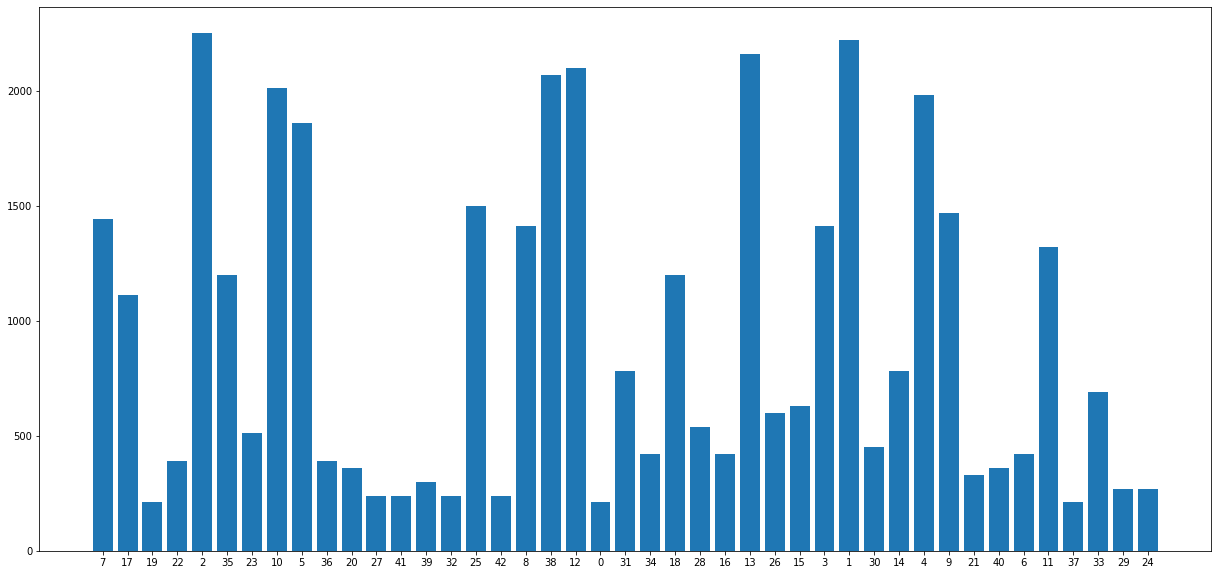

In [8]:
# let's see how many images are there per classes
folders = os.listdir(train_path)
#class_num:no.of samples
samples_dict = {} 

for folder in folders:
    images_in_folder = os.listdir(train_path + '/' + folder)
    samples_dict[folder] = len(images_in_folder)
    
plt.figure(figsize=(21,10))  
plt.bar(*zip(*samples_dict.items()))

In [6]:
print("--> Checking for physical Tensorflow devices")
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

--> Checking for physical Tensorflow devices
: /physical_device:CPU:0
: /physical_device:GPU:0


2022-11-02 16:11:29.180104: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 16:11:29.345677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-02 16:11:29.346414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Processing the training data**

In [9]:

    image_data = []
    image_labels = []
    class_num = len(os.listdir(train_path))
    for i in range(class_num):
        path = train_path +'/'+ str(i)
        images = os.listdir(path)

        for img in images:
            try:
                #print(path+'/'+img)
                image = cv2.imread(path + '/' + img)
                image_fromarray = Image.fromarray(image, 'RGB')
                resize_image = image_fromarray.resize((30, 30))
                image_data.append(np.array(resize_image))
                image_labels.append(i)
            except:
                print("Error in " + img)

image_data = np.array(image_data)
image_labels = np.array(image_labels)
print(image_data.shape, image_labels.shape)

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)
X_train = X_train/255 
X_val = X_val/255

y_train = to_categorical(y_train, class_num)
y_val = to_categorical(y_val, class_num)

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446, 43)
y_valid.shape (11763, 43)


**Create the model**

In [61]:
model = tf.keras.Sequential([
        tfl.Conv2D(filters=16, kernel_size=(3,3), activation='relu',input_shape=(X_train.shape[1:])),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    #after a Conv2D layer with data_format="channels_first", set axis=1 in BatchNormalization.
    #after a Conv2D layer with data_format="channels_last", set axis=-1 in BatchNormalization.
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
        
    
        tfl.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        tfl.MaxPool2D(pool_size=(2,2)),
        tfl.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
        tfl.BatchNormalization(axis=-1),
        tfl.Dropout(rate=0.25),
    
        tfl.Flatten(),
        tfl.Dense(512,activation='relu'),
        tfl.BatchNormalization(),
        tfl.Dropout(rate=0.5),
    
        tfl.Dense(class_num, activation='softmax')
        
])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 28, 28, 16)        448       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 12, 12, 32)        4640      
_________________________________________________________________
batch_normalization_49 (Batc (None, 12, 12, 32)        128       
_________________________________________________________________
dropout_26 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 5, 5, 64)        

**Compiling the model with Adam opmtimization**

In [62]:
from tensorflow.keras.optimizers import Adam
learning_rate = 0.001
epochs = 15

opt = Adam(learning_rate=learning_rate, decay=learning_rate / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [63]:
with tf.device('/GPU:0'):
    epochs = 15
    history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/15
858/858 [==============================] - 8s 8ms/step - loss: 0.8515 - accuracy: 0.7734 - val_loss: 0.1209 - val_accuracy: 0.9660
Epoch 2/15
858/858 [==============================] - 5s 6ms/step - loss: 0.1811 - accuracy: 0.9442 - val_loss: 0.0766 - val_accuracy: 0.9788
Epoch 3/15
858/858 [==============================] - 5s 6ms/step - loss: 0.1164 - accuracy: 0.9634 - val_loss: 0.0714 - val_accuracy: 0.9776
Epoch 4/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0830 - accuracy: 0.9730 - val_loss: 0.0447 - val_accuracy: 0.9869
Epoch 5/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0691 - accuracy: 0.9785 - val_loss: 0.0342 - val_accuracy: 0.9906
Epoch 6/15
858/858 [==============================] - 5s 6ms/step - loss: 0.0516 - accuracy: 0.9838 - val_loss: 0.0268 - val_accuracy: 0.9924
Epoch 7/15
858/858 [==============================] - 6s 7ms/step - loss: 0.0431 - accuracy: 0.9868 - val_loss: 0.0271 - val_accuracy: 0.9923
Epoch 

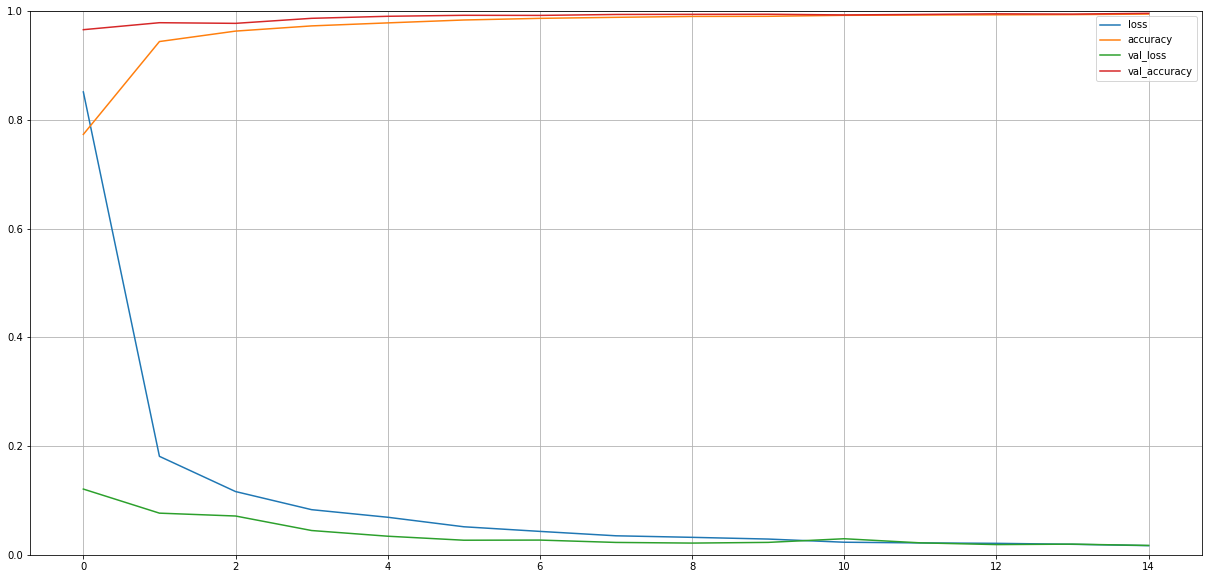

In [64]:
pd.DataFrame(history.history).plot(figsize=(21, 10))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [65]:
from sklearn.metrics import accuracy_score
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

pred = np.argmax(model.predict(X_test), axis=1)
#Accuracy with the test data
print('Test Data accuracy: ',accuracy_score(labels, pred)*100)

Test Data accuracy:  97.56927949326999


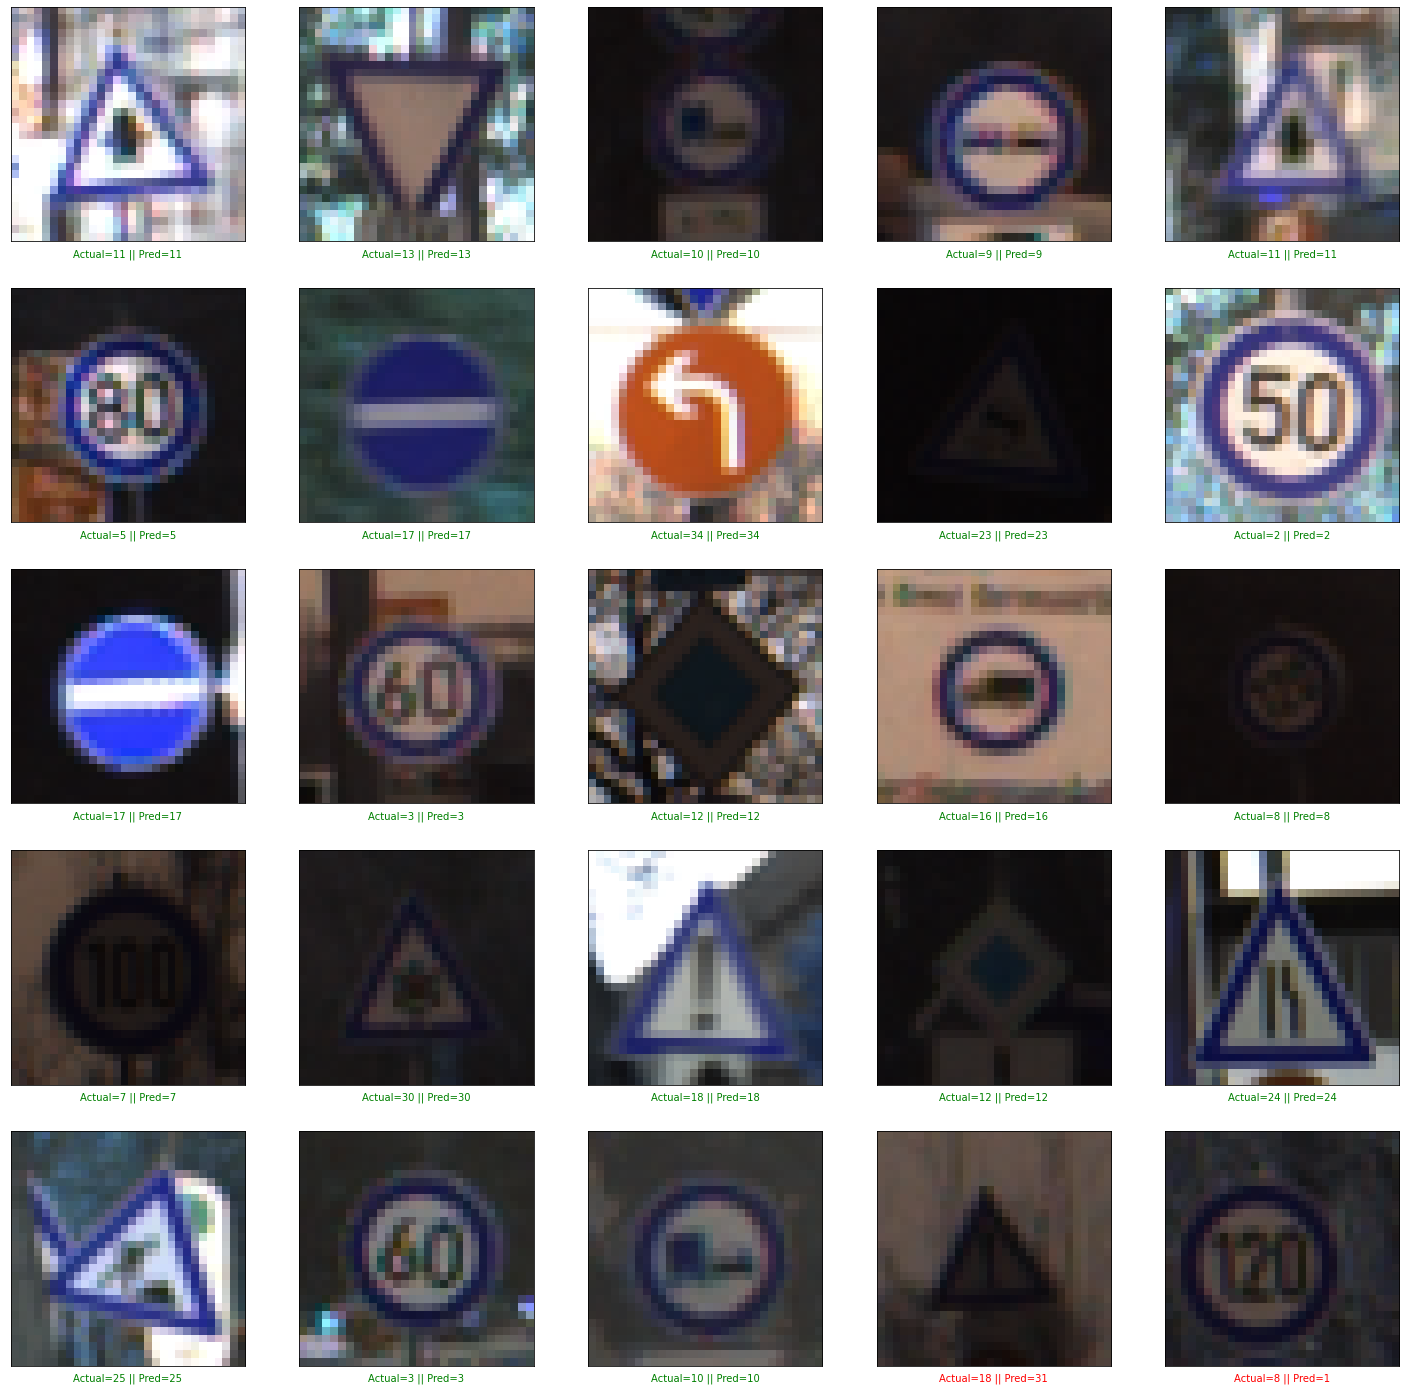

In [68]:
plt.figure(figsize = (25, 25))

start_index = 25
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()